In [215]:
import shap
import numpy as np
import pysubgroup as ps
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from utils import DataEncoding

In [238]:
class Shap_Discovery:

    def __init__(self, train_data, target_data, attr, model=None):
        self.train_data = train_data
        self.target_data = target_data
        self.attr = attr
        self.model = model
    
    def encoding(self, data):
        label_data = data.copy()
        encoded_data = DataEncoding(label_data).label_encoding()
        return encoded_data
        
    def train_model(self, test_size=0.3, params=None):
        
        X = self.encoding(self.train_data)
        y = self.encoding(self.target_data)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7)
        d_train = lgb.Dataset(X_train, label=y_train)
        d_test = lgb.Dataset(X_test, label=y_test)

        params_default = {
            "max_bin": 512,
            "learning_rate": 0.05,
            "boosting_type": "gbdt",
            "objective": "binary",
            "metric": "binary_logloss",
            "num_leaves": 10,
            "verbose": -1,
            "min_data": 100,
            "boost_from_average": True
        }

        if params is None:
            params = params_default
            
        model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)
        self.model = model
        return model
    
    def get_attr_shap_values(self):
        shap_values = self.get_shap_values()
        ind = self.train_data.columns.tolist().index(self.attr)
        attr_shap_values = shap_values[:, ind]
        return attr_shap_values
    
    def get_shap_values(self):
        X = self.encoding(self.train_data)
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(X)
        return shap_values
    
    def get_shap_summary_plot(self):
        X = self.encoding(self.train_data)
        shap_values = self.get_shap_values()
        return shap.summary_plot(shap_values, X)
        
    def get_shap_dependence_plot(self):
        X = self.encoding(self.train_data)
        shap_values = self.get_shap_values()
        for name in self.train_data.columns:
            shap.dependence_plot(name, shap_values, X, display_features=X)
            
    def discovery(self):
        attr_effect = self.get_attr_shap_values()
        df_effect = self.train_data.copy()
        df_effect['effect'] = attr_effect - np.mean(attr_effect)
        target = ps.NumericTarget('effect')
        search_space = ps.create_nominal_selectors(df_effect, ignore=['effect', self.attr])
        task = ps.SubgroupDiscoveryTask(df_effect, target, search_space, qf=ps.StandardQFNumeric(1))
        result = ps.BeamSearch().execute(task)

        df_dis = ps.as_df(df_effect, result, statistics_to_show=ps.all_statistics_numeric)
        return df_dis

In [239]:
adult_data = pd.read_csv('../Datasets/adult_train.csv', index_col=0)
adult_data = adult_data.drop(['education'], axis=1)

X = adult_data.drop('target', axis=1)
y = adult_data[['target']]
attr = 'education-num'

In [240]:
sex_discovery = Shap_Discovery(X, y, attr)
model = sex_discovery.train_model()

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[795]	valid_0's binary_logloss: 0.2769


In [236]:
# sex_discovery.discovery()

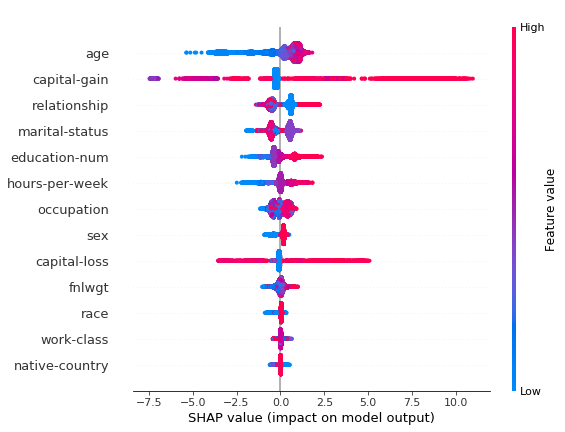

In [248]:
sex_discovery.get_shap_summary_plot()

In [243]:
# sex_discovery.get_shap_dependence_plot()

In [188]:
# adult_data = pd.read_csv('../Datasets/adult_train.csv', index_col=0)
# adult_data = adult_data.drop(['education'], axis=1)
# data = DataEncoding(adult_data).label_encoding()
# df_adult = data

# X = df_adult.drop('target', axis=1)
# y = df_adult['target'].astype(bool)
